In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000112.png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (4).png
/kaggle/input/chest-cts

In [2]:
# The images are in a folder named 'input/natural-images/natural_images'
training_folder_name = '../input/chest-ctscan-images/Data/train'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [3]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.11.0


# **Standardize the images' size**

In [4]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [5]:
training_folder_name = '../input/chest-ctscan-images/Data/train'

# New location for the resized images
train_folder = '../working/data/train'


# Create resized copies of all of the source images
size = (128,128)

# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  


processing folder normal
processing folder large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
processing folder adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Done.


# **Pre Processing / Augmentation**

In [6]:
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader




#####################################################################################################




# Recall that we have resized the images and saved them into
train_folder = '../working/data/train'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read ../working/data/train


# Defining the Convolutional Neural Network



1. Define the model as a sequential layers
2. Introduce the Convolutions. 
    * they are important to create a feature map
3. Introduce the Poolings
    * MaxPooling is used to reduce dimensionality. In MaxPooling, the output value is just the maximum of the input values in each patch (for ex. The maximum pixel in a span of 3 pixels).
4. Flatten the data in order to have a np.array to feed the NN

In particoular, we will apply

1. 16 3x3 Convolution matrix with activation='relu', 
2. A 2x2 MaxPooling
3. 32 3x3 Convolution matrix with activation='relu',
4. A 2x2 MaxPooling
5. 64 3x3 Convolution matrix with activation='relu', 
6. A 2x2 MaxPooling
7. 64 3x3 Convolution matrix with activation='softmax'
8. A 2x2 MaxPooling



In [7]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a softmax function 
        return torch.softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=4, bias=True)
)


# **Training Function**

The traning function we need to define needs the following steps: 

1. Set the model to training mode;
2. Process the images in batches; we will iterate over images in batches. Inside each batches, we have to
    1.  Import labels and features;
    2. Reset the optimizer
    3. Push the data forward through the layers of the model
    4. compute the loss
    5. Backpropagate
3.  Compute the Average Loss of the Model during the Epoch

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

# **Test Function**

1. Set the model to evaluation mode;
2. Process the images in batches; we will iterate over images in batches. Inside each batches, we have to
    1. Get the prediction for each image in the batch
    2. Calculate the loss for the batch
    3. Calculate the accuracy for this batch
3. Calculate the average accuracy and loss for the epoch

In [9]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# **Model Training - Adam Optimizer, Cross Entropy Loss Function**

In [12]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 50
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
	Training batch 1 Loss: 0.929655
	Training batch 2 Loss: 1.024837
	Training batch 3 Loss: 1.052259
	Training batch 4 Loss: 0.952861
	Training batch 5 Loss: 0.988699
	Training batch 6 Loss: 0.880208
	Training batch 7 Loss: 0.961571
	Training batch 8 Loss: 1.034787
	Training batch 9 Loss: 0.819013
Training set: Average loss: 0.960432
Validation set: Average loss: 1.002859, Accuracy: 137/184 (74%)

Epoch: 2
	Training batch 1 Loss: 0.901094
	Training batch 2 Loss: 1.020989
	Training batch 3 Loss: 0.965952
	Training batch 4 Loss: 0.981597
	Training batch 5 Loss: 0.985258
	Training batch 6 Loss: 0.886930
	Training batch 7 Loss: 1.010613
	Training batch 8 Loss: 1.047599
	Training batch 9 Loss: 0.997828
Training set: Average loss: 0.977540
Validation set: Average loss: 1.040238, Accuracy: 127/184 (69%)

Epoch: 3
	Training batch 1 Loss: 0.949516
	Training batch 2 Loss: 0.996832
	Training batch 3 Loss: 0.886673
	Training batch 4 Loss: 0.934241
	Training batch 5 Loss: 0.

# **Loss History**

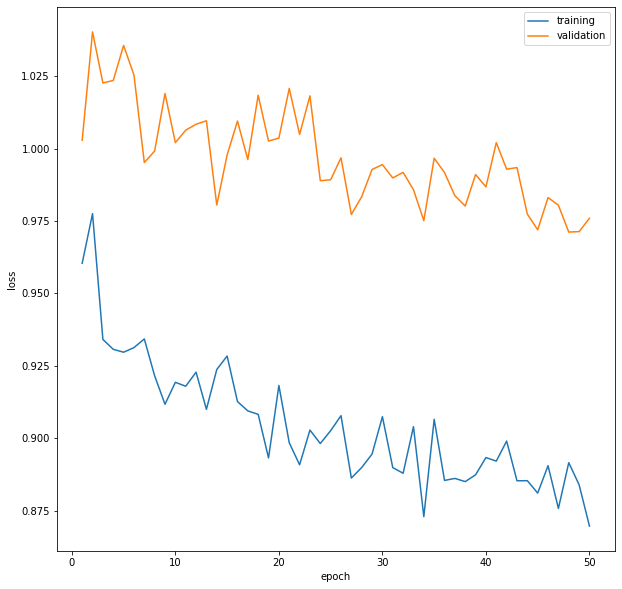

In [14]:
plt.figure(figsize=(10,10))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()